# **Face Mask Detection**

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

plt.style.use('ggplot')

### **Split Folder Untuk Train Dan Validation**

In [2]:
import splitfolders

splitfolders.ratio('Dataset', output="splitted", ratio=(0.8, 0.2))

Copying files: 8982 files [00:00, 9920.50 files/s]


### **Preprocessing Gambar**

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( 
      rescale = 1.0/255.,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(
    'splitted/train',
    batch_size=64,
    class_mode='categorical',
    target_size=(224, 224)
)     

validation_generator = test_datagen.flow_from_directory(
    'splitted/val',
    batch_size=20,
    class_mode  = 'categorical',
    target_size = (224, 224)
)

Found 7185 images belonging to 3 classes.
Found 1797 images belonging to 3 classes.


### **Import Pretrained Model InceptionV3**

In [4]:
pre_trained_model = tf.keras.applications.InceptionV3(
    input_shape = (224, 224, 3),
    include_top=False, 
    weights='imagenet'
)

2022-03-27 08:29:17.759001: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-27 08:29:18.243920: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38421 MB memory:  -> device: 0, name: A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


In [ ]:
pre_trained_model.summary()

In [6]:
for layer in pre_trained_model.layers:
    layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

### **Menambahkan Layer Tambahan Untuk Training Model**

In [7]:
x = layers.Flatten()(last_output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense (3, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(
    optimizer = 'adam', 
    loss = 'categorical_crossentropy', 
    metrics = ['accuracy']
)

### **Fine-tuned Model**

In [8]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=10,
    epochs=8,
    validation_steps=8,
    verbose=2
)

Epoch 1/8


2022-03-27 08:29:24.529132: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8301
2022-03-27 08:29:25.721521: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 - 11s - loss: 4.8010 - accuracy: 0.5984 - val_loss: 1.0888 - val_accuracy: 0.8188 - 11s/epoch - 1s/step
Epoch 2/8
10/10 - 6s - loss: 0.8773 - accuracy: 0.8469 - val_loss: 0.2748 - val_accuracy: 0.9187 - 6s/epoch - 622ms/step
Epoch 3/8
10/10 - 6s - loss: 0.6305 - accuracy: 0.8703 - val_loss: 0.2286 - val_accuracy: 0.9438 - 6s/epoch - 622ms/step
Epoch 4/8
10/10 - 6s - loss: 0.3320 - accuracy: 0.9031 - val_loss: 0.0652 - val_accuracy: 0.9750 - 6s/epoch - 619ms/step
Epoch 5/8
10/10 - 6s - loss: 0.2102 - accuracy: 0.9328 - val_loss: 0.1173 - val_accuracy: 0.9688 - 6s/epoch - 617ms/step
Epoch 6/8
10/10 - 6s - loss: 0.1283 - accuracy: 0.9500 - val_loss: 0.0906 - val_accuracy: 0.9688 - 6s/epoch - 630ms/step
Epoch 7/8
10/10 - 6s - loss: 0.1716 - accuracy: 0.9344 - val_loss: 0.0128 - val_accuracy: 1.0000 - 6s/epoch - 621ms/step
Epoch 8/8
10/10 - 6s - loss: 0.1394 - accuracy: 0.9547 - val_loss: 0.0778 - val_accuracy: 0.9812 - 6s/epoch - 616ms/step


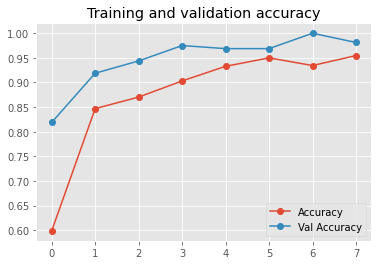

In [40]:
acc = history.history['accuracy' ]
val_acc = history.history['val_accuracy' ]
epochs = range(len(acc)) 

plt.plot(epochs, acc, label="Accuracy", marker='o')
plt.plot(epochs, val_acc, label="Val Accuracy", marker='o')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

### **Contoh Prediksi Model**

In [28]:
def predict(path):
    img = mpimg.imread(path)
    imgplot = plt.imshow(img)
    
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    img = np.reshape(img,[1,224,224,3])
    img = img/255.0

    classes = model.predict(img)
    predicted = np.argmax(classes, axis=1)
    
    if predicted == 0:
        print(predicted, "Penggunaan Masker Tidak Benar, akurasi prediksi :", classes[0][predicted]) 
    elif predicted == 1:
        print(predicted, "Menggunakan Masker Dengan Benar, akurasi prediksi :", classes[0][predicted])
    else:
        print(predicted, "Tidak Menggunakan Masker, akurasi prediksi :", classes[0][predicted])
        
    print('\n')

[0] Penggunaan Masker Tidak Benar, akurasi prediksi : [0.96340775]




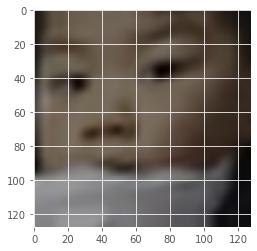

In [29]:
predict('splitted/val/mask_weared_incorrect/987.png')

[1] Menggunakan Masker Dengan Benar, akurasi prediksi : [0.9886983]




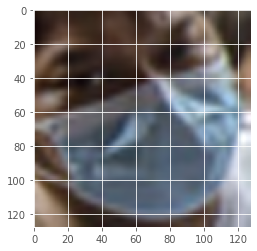

In [34]:
predict('splitted/val/with_mask/1583.png')

[2] Tidak Menggunakan Masker, akurasi prediksi : [0.9999883]




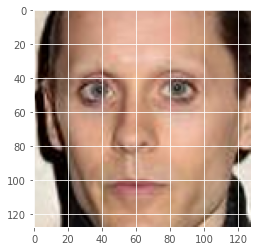

In [31]:
predict('splitted/val/without_mask/1042.png')

[1] Menggunakan Masker Dengan Benar, akurasi prediksi : [0.9837494]




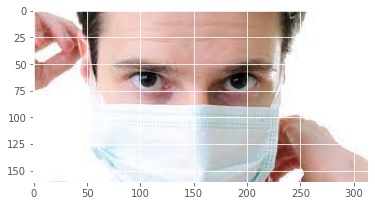

In [45]:
predict('Contoh.jpg')